In [1]:
import matplotlib
import pandas as pd
import re
import urllib.request

draft_url = 'http://dolphinsim.com/clmanager/epbl/index_dra.shtml'
%matplotlib inline

pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

POS_FACTOR = 3
POT_FACTOR = 3.5
STAT_FACTOR = 3.5

def attr_score(val, factor):
    return (val//factor)**2

def stat_score(df, in_col, out_col, multiplier=1):
    in_min = df[in_col].min()
    in_max = df[in_col].max()
    df[in_col] = df[in_col].apply(lambda x: x - in_min)
    factor = (in_max - in_min) // 25
    df[out_col] = df[in_col].apply(lambda x: attr_score(x, factor) * multiplier)
    return df

In [2]:
draft_page_response = urllib.request.urlopen(draft_url)
draft_page = draft_page_response.read()
draft_page_response.close()

In [3]:
pre_blocks = draft_page.__str__().split('<pre>')[4:]
words_regex = re.compile('\s+')
block_names = ['BAT', 'PIT', 'ATT']
df_dict = {}
for pre_block, block_name in zip(pre_blocks, block_names):
    pre_block = pre_block.split('</pre>')[0].split('\\n')
    columns = None
    player_dict = {}
    for player in pre_block:
        player = player.strip()
        if len(player) == 0:
            continue
        player = words_regex.split(player)
        if columns is None:
            columns = player
            if columns[-1] == 'H':
                columns[-1] = 'Hnd'
            for column in columns:
                player_dict[column] = []
            #print('{0} Columns {1}: {2}'.format(block_name, columns[0], ', '.join(columns[1:])))
            continue
        #print('{0} Player {1}: {2}'.format(block_name, player[0], ', '.join(player[1:])))
        for column, value in zip(columns, player):
            player_dict[column].append(value)
    
    #for column in player_dict.keys():
    #    print('{0}: {1} values'.format(column, len(player_dict[column])))
    df_dict[block_name] = pd.DataFrame(data=player_dict).set_index(columns[0])
    
df = None
prev_block_name = None
for block_name in block_names:
    part_df = df_dict[block_name]
    if df is None:
        df = part_df
        prev_block_name = block_name
    else:
        df = df.join(part_df, rsuffix='_' + block_name)

df = df.drop(['Name_PIT', 'Name_ATT', 'Ps_ATT', 'In', 'Rnk'], axis=1)
rename_dict = dict(zip(['BB', 'H', 'HR', 'SO', 'Hnd', 'OBP'], ['BB_BAT', 'H_BAT', 'HR_BAT', 'SO_BAT', 'Hnd_BAT', 'OBP_PIT']))
df = df.rename(columns=rename_dict)
print(df.columns)

Index(['2B', '3B', 'AB', 'Avg', 'BB_BAT', 'E', 'H_BAT', 'HR_BAT', 'Hnd_BAT',
       'Name', 'PA', 'PM', 'Ps', 'RBI', 'SB', 'SBA', 'SO_BAT', 'BB_PIT', 'BS',
       'Bt', 'ER', 'ERA', 'G', 'H_PIT', 'HR_PIT', 'Hnd_PIT', 'IP', 'L',
       'OBP_PIT', 'SO_PIT', 'SV', 'St', 'W', 'Ag', 'Ar', 'BH', 'Cn', 'Co',
       'Df', 'Dr', 'Ds', 'GP', 'PH', 'Pw', 'Rst', 'Sp', 'St_ATT', 'Tr'],
      dtype='object')


In [4]:
attrs = ['Dr', 'Ds', 'Sp', 'Co', 'Pw', 'Df', 'Ar', 'Cn']
scored=df
pos_weight = 15
stat_weight = 15
pot_weight = 10
for attr in attrs:
    attr_col = attr + '_score'
    scored[attr_col] = scored[attr].apply(lambda x: attr_score(int(x),2))
scored['Stat_raw'] = 0
scored['Stat_score'] = 0
scored['Ps_raw'] = 0
scored['Ps_score'] = 0
scored['Group'] = 0

scored['AB'] = scored['AB'].astype(int)
scored['BB_BAT'] = scored['BB_BAT'].astype(int)
scored['AB_avg'] = scored['AB'] + scored['BB_BAT']
scored = stat_score(scored, 'AB_avg', 'AB_score')

scored['GP'] = scored['GP'].astype(int)
scored = stat_score(scored, 'GP', 'GP_score')
   
scored['Tr_score'] = scored['Tr'].apply(lambda x: attr_score(50-int(x)-25, 8))
scored['Ag_score'] = scored['Ag'].apply(lambda x: attr_score(23-int(x[:2]), 1))
scored['Pot_raw'] = (scored['Tr_score'] + scored['Ag_score'])
scored = stat_score(scored, 'Pot_raw', 'Pot_score', pot_weight)

scored['K_BAT'] = (1 - (scored['SO_BAT'].astype(int) / (scored['AB'].astype(int) + scored['BB_BAT'].astype(int)))) * 1000
scored['K_BAT'] = scored['K_BAT'].apply(lambda x: 0 if str(x) == 'nan' else x)
scored = stat_score(scored, 'K_BAT', 'K_score')

scored['AB_score'] = scored['AB'].astype(int).apply(lambda x: 150 if x < 150 else x)
scored['OBP_BAT'] = ((scored['H_BAT'].astype(int) + scored['BB_BAT'].astype(int)) / \
                    (scored['AB_score'] + scored['BB_BAT'].astype(int))) * 1000
scored['OBP_BAT'] = scored['OBP_BAT'].apply(lambda x: 0.00 if str(x) == 'nan' else x)
scored = stat_score(scored, 'OBP_BAT', 'OBP_score')

scored['SB'] = scored['SB'].astype(int)
scored = stat_score(scored, 'SB', 'SB_score')

scored['TB'] = scored['H_BAT'].astype(int) + scored['2B'].astype(int) + scored['3B'].astype(int) * 2 \
                + scored['HR_BAT'].astype(int) * 3
scored['SLG'] = (scored['TB'] / scored['AB_score']) * 1000
scored = stat_score(scored, 'SLG', 'SLG_score')

scored['AVG_BAT'] = (scored['H_BAT'].astype(int) / scored['AB_score']) * 1000
scored['AVG_BAT'] = scored['AVG_BAT'].apply(lambda x: 0.00 if str(x) == 'nan' else x)
scored = stat_score(scored, 'AVG_BAT', 'AVG_score')

scored.sort_values(by=['Pot_score', 'OBP_score', 'AVG_score', 'SLG_score', 'SB_score', 'K_score', 'OBP_BAT', 'K_BAT'], ascending=False).loc[:, ['Pot_score', 'Ag', 'Tr', 'Tr_score', 'GP_score', 'GP', 'AB_score', 'AB', 'BB_BAT', 'OBP_score', 'AVG_score', 'SLG_score', 'SB_score', 'K_score']]

,Pot_score,Ag,Tr,Tr_score,GP_score,GP,AB_score,AB,BB_BAT,OBP_score,AVG_score,SLG_score,SB_score,K_score
Num,,,,,,,,,,,,,,
6431,7840,18r,4,4,1156,69,257,257,54,676,625,400,64,441
4344,7840,18r,8,4,1156,69,239,239,50,576,529,225,16,400
2038,7840,18r,6,4,841,58,237,237,35,484,441,289,25,400
6801,7840,18r,4,4,1296,73,304,304,37,441,484,324,36,484
775,7840,18r,8,4,1156,68,238,238,30,441,484,225,25,400
6928,7840,18r,9,4,1089,66,256,256,29,441,441,289,16,441
5842,7840,18r,9,4,1225,70,262,262,46,441,400,324,4,484
2911,7840,18r,8,4,961,62,248,248,36,441,400,256,49,361
3469,7840,18r,9,4,1024,65,273,273,38,400,400,361,36,441


In [5]:
catchers = scored[scored['Ps'] == 'C']
infielders = scored[scored['Ps'] == 'IF']
outfielders = scored[scored['Ps'] == 'OF']
pitchers = scored[scored['Ps'] == 'P']

catchers['Ps_raw'] = catchers['Co_score'] * 8 + catchers['Pw_score'] * 3 + catchers['Ds_score'] * 5 + \
                     catchers['Ar_score'] * 3 + catchers['Dr_score'] + catchers['Sp_score'] + catchers['Df_score']  
catchers = stat_score(catchers, 'Ps_raw', 'Ps_score', pos_weight)
catchers['PA_avg'] = (1 - (catchers['PA'].astype(int) / catchers['AB'].astype(int))) * 1000
catchers['PA_avg'] = catchers['PA_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
catchers = stat_score(catchers, 'PA_avg', 'PA_score')
catchers['PM_avg'] = (1 - (catchers['PM'].astype(int) / catchers['AB'].astype(int))) * 1000
catchers['PM_avg'] = catchers['PM_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
catchers = stat_score(catchers, 'PM_avg', 'PM_score')
catchers['Stat_raw'] = (catchers['OBP_score'] * 8 + \
                         catchers['AVG_score'] * 4 + \
                         catchers['SLG_score'] * 2 + \
                         catchers['PA_score'] * 2 + \
                         catchers['PM_score'] * 2 + \
                         catchers['SB_score'] + \
                         catchers['K_score']) * catchers['GP_score']
catchers['Group'] = '1'
catchers = stat_score(catchers, 'Stat_raw', 'Stat_score', stat_weight)

infielders['Ps_raw'] = infielders['Co_score'] * 8 + infielders['Pw_score'] * 3 + infielders['Ds_score'] * 5 + \
                     infielders['Ar_score'] + infielders['Dr_score'] + infielders['Sp_score'] * 2 + \
                     infielders['Df_score'] * 2  
infielders = stat_score(infielders, 'Ps_raw', 'Ps_score', pos_weight)
infielders['PA_avg'] = (infielders['PA'].astype(int) / infielders['AB'].astype(int)) * 1000
infielders['PA_avg'] = infielders['PA_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
infielders = stat_score(infielders, 'PA_avg', 'PA_score')
infielders['PM_avg'] = (infielders['PM'].astype(int) / infielders['AB'].astype(int)) * 1000
infielders['PM_avg'] = infielders['PM_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
infielders = stat_score(infielders, 'PM_avg', 'PM_score')
infielders['Stat_raw'] = (infielders['OBP_score'] * 8 + \
                         infielders['AVG_score'] * 4 + \
                         infielders['SLG_score'] * 2 + \
                         infielders['PA_score'] * 2 + \
                         infielders['PM_score'] * 2 + \
                         infielders['SB_score'] + \
                         infielders['K_score']) * infielders['GP_score']
infielders['Group'] = '2'
infielders = stat_score(infielders, 'Stat_raw', 'Stat_score', stat_weight)

outfielders['Ps_raw'] = outfielders['Co_score'] * 8 + outfielders['Pw_score'] * 3 + outfielders['Ds_score'] * 5 + \
                     outfielders['Ar_score'] * 2 + outfielders['Dr_score'] + outfielders['Sp_score'] * 2 + \
                     outfielders['Df_score'] * 3
outfielders = stat_score(outfielders, 'Ps_raw', 'Ps_score', pos_weight)
outfielders['PA_avg'] = (outfielders['PA'].astype(int) / outfielders['AB'].astype(int)) * 1000
outfielders['PA_avg'] = outfielders['PA_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
outfielders = stat_score(outfielders, 'PA_avg', 'PA_score')
outfielders['PM_avg'] = (outfielders['PM'].astype(int) / outfielders['AB'].astype(int)) * 1000
outfielders['PM_avg'] = outfielders['PM_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
outfielders = stat_score(outfielders, 'PM_avg', 'PM_score')
outfielders['Stat_raw'] = (outfielders['OBP_score'] * 8 + \
                         outfielders['AVG_score'] * 4 + \
                         outfielders['SLG_score'] * 2 + \
                         outfielders['PA_score'] * 2 + \
                         outfielders['PM_score'] * 2 + \
                         outfielders['SB_score'] + \
                         outfielders['K_score']) * outfielders['GP_score']
outfielders['Group'] = '3'
outfielders = stat_score(outfielders, 'Stat_raw', 'Stat_score', stat_weight)

pitchers['Ps_raw'] = pitchers['Co_score'] + pitchers['Pw_score'] + pitchers['Ds_score'] + pitchers['Ar_score'] * 8 + \
                     pitchers['Dr_score'] * 4 + pitchers['Sp_score'] + pitchers['Df_score'] + pitchers['Cn_score'] * 12
pitchers = stat_score(pitchers, 'Ps_raw', 'Ps_score', pos_weight)
pitchers['IP_avg'] = pitchers['IP'].apply(lambda x: float(x))
pitchers['IP_avg'] = pitchers['IP_avg'].apply(lambda x: 80.0 if x > 80.0 else x)
pitchers = stat_score(pitchers, 'IP_avg', 'IP_score')
pitchers['OBP_PIT_avg'] = pitchers['OBP_PIT'].apply(lambda x: (1 - float(x)) * 1000) * pitchers['IP_score'] 
pitchers = stat_score(pitchers, 'OBP_PIT_avg', 'OBP_PIT_score')
pitchers['ERA_avg'] = pitchers['ERA'].apply(lambda x: 20.0 - float(x)) * pitchers['IP_score']
pitchers = stat_score(pitchers, 'ERA_avg', 'ERA_score')
pitchers['Stat_raw'] = pitchers['OBP_PIT_avg'] * 8 + \
                         pitchers['ERA_avg'] * 12# + \
                         #pitchers['IP_score'] * 8
pitchers['Group'] = '4'
pitchers = stat_score(pitchers, 'Stat_raw', 'Stat_score', stat_weight)

scored.update(catchers.loc[:, ['Ps_raw', 'Ps_score', 'Stat_raw', 'Stat_score', 'Group']])
scored.update(infielders.loc[:, ['Ps_raw', 'Ps_score', 'Stat_raw', 'Stat_score', 'Group']])
scored.update(outfielders.loc[:, ['Ps_raw', 'Ps_score', 'Stat_raw', 'Stat_score', 'Group']])
scored.update(pitchers.loc[:, ['Ps_raw', 'Ps_score', 'Stat_raw', 'Stat_score', 'Group']])

C:\Users\Jesse\Anaconda3\envs\dolphinsim\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Jesse\Anaconda3\envs\dolphinsim\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Jesse\Anaconda3\envs\dolphinsim\lib\site-packages\ipykernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

In [6]:
scored['Final_score'] = (scored['Stat_score'] * STAT_FACTOR) + (scored['Ps_score'] * POS_FACTOR) + (scored['Pot_score'] * POT_FACTOR)
scored.sort_values(by=['Final_score'], ascending=False).loc[:, ['Group', 'Ps', 'Ag', 'Final_score', 'Stat_score', 'Ps_score', 'Pot_score', 'OBP_score', 'AVG_score', 'SLG_score', 'SB_score', 'K_score', 'Ps_raw']]


,Group,Ps,Ag,Final_score,Stat_score,Ps_score,Pot_score,OBP_score,AVG_score,SLG_score,SB_score,K_score,Ps_raw
Num,,,,,,,,,,,,,
4595,1,C,18r,72845.0,2160,12615,7840,256,196,169,169,324,59
6436,4,P,18r,68592.5,6615,6000,7840,0,0,0,0,0,102
5245,2,IF,19r,67175.0,7260,10935,2560,484,400,361,729,400,54
319,2,IF,20r,66832.5,2535,18375,810,169,169,64,4,256,70
2196,4,P,18r,66230.0,4860,7260,7840,0,0,0,0,0,112
2314,4,P,18r,65337.5,7935,3375,7840,0,0,0,0,0,77
4766,4,P,18r,64032.5,7935,2940,7840,0,0,0,0,0,73
775,1,C,18r,62112.5,6615,3840,7840,441,484,225,25,400,32
937,4,P,18r,61445.0,6000,4335,7840,0,0,0,0,0,87


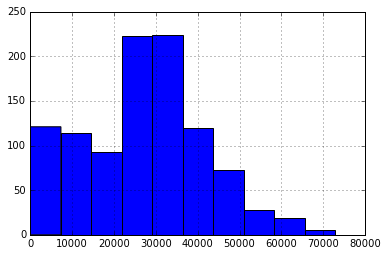

In [7]:
scored['Final_score'].hist()

In [8]:
len(scored[scored['Ps_score'] >= 3500])

186

In [9]:
scored.sort_values(by=['Final_score'], ascending=False).\
    head(500).loc[:, 'Group'].to_csv('C:\\Users\\Jesse\\Anaconda3\\envs\\dolphinsim\\top500_5.csv', index_label='num', sep=' ')

In [10]:
scored.sort_values(by=['Final_score'], ascending=False).head(90).loc[:, ['Name', 'Ps', 'Ag', 'Dr', 'Ds', 
                                                                         'Sp', 'Co', 'Pw', 'Df', 'Ar', 'Cn', 'Tr', 
                                                                         'BH', 'PH', 'Avg', 'OBP_PIT', 'Final_score', 
                                                                         'Stat_score', 'Ps_score', 'Pot_score']] 

,Name,Ps,Ag,Dr,Ds,Sp,Co,Pw,Df,Ar,Cn,Tr,BH,PH,Avg,OBP_PIT,Final_score,Stat_score,Ps_score,Pot_score
Num,,,,,,,,,,,,,,,,,,,,
4595,G.Bellan,C,18r,8,3,6,1,7,1,2,1,8,R,R,0.194,NaN,72845.0,2160,12615,7840
6436,T.Clouser,P,18r,10,2,0,1,2,0,0,1,6,L,L,0.000,0.370,68592.5,6615,6000,7840
5245,A.Ritter,IF,19r,8,2,6,1,4,2,2,1,11,R,R,0.267,NaN,67175.0,7260,10935,2560
319,F.Moss,IF,20r,9,3,1,1,6,6,5,2,12,L,L,0.170,NaN,66832.5,2535,18375,810
2196,B.Ragan,P,18r,10,1,1,1,1,1,1,2,9,R,R,0.000,0.377,66230.0,4860,7260,7840
2314,I.Ortiz,P,18r,8,2,0,1,1,1,1,3,9,R,R,0.000,0.328,65337.5,7935,3375,7840
4766,L.Dejesus,P,18r,8,0,0,1,2,1,2,1,5,S,L,0.000,0.328,64032.5,7935,2940,7840
775,P.Graves,C,18r,9,2,0,2,2,2,1,1,8,L,L,0.290,NaN,62112.5,6615,3840,7840
937,E.Lemmo,P,18r,8,2,0,3,2,1,2,2,9,R,R,0.000,0.415,61445.0,6000,4335,7840


In [14]:
scored[scored['Ps'] == 'P'].sort_values(by='Final_score', ascending=False).loc[:, ['Name', 'Final_score', 'Stat_score', 
                                                                                   'ERA', 'OBP_PIT', 'Ps_score', 
                                                                                   'Pot_score']].head(150)

,Name,Final_score,Stat_score,ERA,OBP_PIT,Ps_score,Pot_score
Num,,,,,,,
6754,J.Silva,78460,8640,1.35,0.206,10935,160
3243,W.Lamb,69340,9375,1.38,0.189,6000,7840
1570,E.Stratton,66460,7935,1.92,0.231,8640,160
2699,C.Wagner,66310,8640,1.68,0.209,7935,10
6268,M.Martinez,66040,7935,1.92,0.246,6615,7840
6956,J.Sides,58360,7935,1.43,0.223,6615,160
847,M.Link,58200,7935,2.11,0.232,6615,0
4247,T.Mitchell,57430,4860,4.34,0.309,7935,6250
6021,D.Mills,56550,7935,1.84,0.235,6000,810
